In [13]:
import os
import json
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from tqdm import tqdm
import time
import cv2
import segmentation_models_pytorch as smp

try:
    from shapely import wkt
except:
    from shapely.wkt import loads as wkt_loads
    class wkt:
        loads = staticmethod(wkt_loads)

In [22]:
# --- Albumentations Transforms ---
train_tf = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(0.2, 0.2),
    A.GaussNoise(var_limit=(5, 25)),
    A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(224,224),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
], additional_targets={'image_pre': 'image'})

/tmp/ipykernel_4022758/469860123.py:7: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 25)),


In [15]:
# --- Crop Polygon ---
def crop_polygon(image, poly, pad=4):
    xs, ys = poly[:, 0], poly[:, 1]
    x1 = max(0, int(xs.min()) - pad)
    x2 = min(image.shape[1], int(xs.max()) + pad)
    y1 = max(0, int(ys.min()) - pad)
    y2 = min(image.shape[0], int(ys.max()) + pad)
    crop = image[y1:y2, x1:x2]
    return crop


# --- Dataset ---
class XBD_BuildingDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_dir = os.path.join(root, "images")
        self.lbl_dir = os.path.join(root, "labels")
        self.transform = transform
        self.samples = []

        files = sorted(os.listdir(self.lbl_dir))

        # Map pre → post
        for f in tqdm(files, desc=f"Indexing {root}"):
            if not f.endswith("_pre_disaster.json"):
                continue

            base = f.replace("_pre_disaster.json", "")

            pre_json = os.path.join(self.lbl_dir, f)
            post_json = os.path.join(self.lbl_dir, base + "_post_disaster.json")
            pre_img = os.path.join(self.img_dir, base + "_pre_disaster.png")
            post_img = os.path.join(self.img_dir, base + "_post_disaster.png")

            if not (os.path.exists(pre_json) and
                    os.path.exists(post_json) and
                    os.path.exists(pre_img) and
                    os.path.exists(post_img)):
                continue

            pre_data = json.load(open(pre_json))
            post_data = json.load(open(post_json))

            # Pre polygons
            pre_map = {}
            for b in pre_data["features"]["xy"]:
                uid = b["properties"]["uid"]
                poly = np.array(wkt.loads(b["wkt"]).exterior.coords)
                pre_map[uid] = poly

            # Post mapping
            for b in post_data["features"]["xy"]:
                uid = b["properties"]["uid"]
                subtype = b["properties"]["subtype"]

                if subtype not in ["no-damage", "minor-damage", "major-damage", "destroyed"]:
                    continue

                if uid not in pre_map:
                    continue

                poly = pre_map[uid]
                self.samples.append((pre_img, post_img, poly, subtype))

        self.dmg_map = {
            "no-damage": 0,
            "minor-damage": 1,
            "major-damage": 2,
            "destroyed": 3
        }

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pre_path, post_path, poly, subtype = self.samples[idx]

        pre = np.array(Image.open(pre_path).convert("RGB"))
        post = np.array(Image.open(post_path).convert("RGB"))

        # Crop building
        pre_crop = crop_polygon(pre, poly)
        post_crop = crop_polygon(post, poly)

        # Resize
        pre_crop = cv2.resize(pre_crop, (224, 224))
        post_crop = cv2.resize(post_crop, (224, 224))

        # Augment POST
        if self.transform:
            aug = self.transform(image=post_crop)
            post_tensor = aug["image"]
        else:
            post_tensor = ToTensorV2()(image=post_crop)["image"]

        # Normalize PRE
        pre_norm = A.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225)
        )(image=pre_crop)["image"]
        pre_tensor = ToTensorV2()(image=pre_norm)["image"]

        label = torch.tensor(self.dmg_map[subtype]).long()

        return pre_tensor, post_tensor, label

In [16]:
# --- Model ---
import segmentation_models_pytorch as smp


class SiameseMiTEncoder(nn.Module):
    def __init__(self, backbone="mit_b1"):
        super().__init__()
        self.enc = smp.encoders.get_encoder(backbone, weights="imagenet")
        self.out_dim = self.enc.out_channels[-1]

    def forward(self, x):
        feats = self.enc(x)
        last = feats[-1]
        pooled = last.mean(dim=[2, 3])
        return pooled


class DamageClassifier(nn.Module):
    def __init__(self, backbone="mit_b1", num_classes=4):
        super().__init__()
        self.encoder = SiameseMiTEncoder(backbone)
        D = self.encoder.out_dim

        self.fusion = nn.Sequential(
            nn.Linear(D * 2, D),
            nn.ReLU(),
            nn.Linear(D, D),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, pre, post):
        f_pre = self.encoder(pre)
        f_post = self.encoder(post)
        fused = torch.cat([f_pre, f_post], dim=1)
        f = self.fusion(fused)
        out = self.classifier(f)
        return out


# --- Loss ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        return ((1 - pt) ** self.gamma * ce).mean()


def total_loss(logits, targets):
    l1 = FocalLoss()(logits, targets)
    l2 = F.cross_entropy(logits, targets, label_smoothing=0.1)
    return 0.7 * l1 + 0.3 * l2

In [17]:
# --- Training ---
device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = XBD_BuildingDataset("train", transform=train_tf)
val_ds = XBD_BuildingDataset("hold", transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)

# Fake loading bar
with tqdm(total=100, desc="Model Loading") as pbar:
    for i in range(4):
        if i == 2:
            model = DamageClassifier(backbone="mit_b2").to(device)
        time.sleep(0.2)
        pbar.update(25)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler("cuda")


# Test run
pre, post, lbl = next(iter(train_loader))
pre, post = pre.to(device), post.to(device)
with torch.no_grad():
    out = model(pre, post)
print("Output shape:", out.shape)

Model Loading: 100%|██████████| 100/100 [00:01<00:00, 66.47it/s]


Output shape: torch.Size([32, 4])


In [18]:
# --- Train one epoch ---
def train_epoch():
    model.train()
    tot = 0

    for pre, post, lbl in tqdm(train_loader):
        pre, post, lbl = pre.to(device), post.to(device), lbl.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            out = model(pre, post)
            loss = total_loss(out, lbl)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        tot += loss.item()

    return tot / len(train_loader)


# --- Validation ---
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# --- Validation with full metrics ---
def validate():
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for pre, post, lbl in val_loader:
            pre, post = pre.to(device), post.to(device)
            out = model(pre, post)
            pred = out.argmax(1).cpu().numpy()
            lbl  = lbl.cpu().numpy()

            all_preds.extend(pred)
            all_labels.extend(lbl)

    all_preds  = np.array(all_preds)
    all_labels = np.array(all_labels)

    # ---- Compute metrics ----
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")
    per_class_f1 = f1_score(all_labels, all_preds, average=None)
    per_class_precision = precision_score(all_labels, all_preds, average=None)
    per_class_recall = recall_score(all_labels, all_preds, average=None)

    return weighted_f1, per_class_f1, per_class_precision, per_class_recall


# --- Full Training Loop ---
best_f1 = 0

class_names = ["no-damage", "minor-damage", "major-damage", "destroyed"]
train_losses = []
val_f1s = []

for e in range(6):
    loss = train_epoch()
    weighted_f1, f1s, precs, recs = validate()

    train_losses.append(loss)
    val_f1s.append(weighted_f1)

    print("\n======================")
    print(f"Epoch {e+1}")
    print(f"Train loss: {loss:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")
    print("======================")
    print("Per-class metrics:")
    for i, name in enumerate(class_names):
        print(f"{name:12s} | F1={f1s[i]:.4f} | Prec={precs[i]:.4f} | Rec={recs[i]:.4f}")
    print("======================\n")

    # Save best model
    if weighted_f1 > best_f1:
        best_f1 = weighted_f1
        torch.save(model.state_dict(), "best_building_classifier.pth")
        print(f"Saved best model (Weighted F1 {best_f1:.4f})\n")


100%|██████████| 4994/4994 [41:29<00:00,  2.01it/s]



Epoch 1
Train loss: 0.3732
Weighted F1: 0.8186
Per-class metrics:
no-damage    | F1=0.9139 | Prec=0.8659 | Rec=0.9675
minor-damage | F1=0.4292 | Prec=0.7286 | Rec=0.3042
major-damage | F1=0.6051 | Prec=0.6102 | Rec=0.6000
destroyed    | F1=0.7790 | Prec=0.8546 | Rec=0.7156

Saved best model (Weighted F1 0.8186)



100%|██████████| 4994/4994 [41:36<00:00,  2.00it/s]



Epoch 2
Train loss: 0.3129
Weighted F1: 0.8600
Per-class metrics:
no-damage    | F1=0.9335 | Prec=0.9137 | Rec=0.9541
minor-damage | F1=0.6338 | Prec=0.6905 | Rec=0.5857
major-damage | F1=0.6247 | Prec=0.6573 | Rec=0.5952
destroyed    | F1=0.7953 | Prec=0.8237 | Rec=0.7689

Saved best model (Weighted F1 0.8600)



100%|██████████| 4994/4994 [41:27<00:00,  2.01it/s]



Epoch 3
Train loss: 0.2935
Weighted F1: 0.8545
Per-class metrics:
no-damage    | F1=0.9312 | Prec=0.9164 | Rec=0.9465
minor-damage | F1=0.6222 | Prec=0.6538 | Rec=0.5936
major-damage | F1=0.5906 | Prec=0.6427 | Rec=0.5464
destroyed    | F1=0.8014 | Prec=0.7992 | Rec=0.8037



100%|██████████| 4994/4994 [41:17<00:00,  2.02it/s]



Epoch 4
Train loss: 0.2799
Weighted F1: 0.8539
Per-class metrics:
no-damage    | F1=0.9292 | Prec=0.9065 | Rec=0.9531
minor-damage | F1=0.6451 | Prec=0.6372 | Rec=0.6532
major-damage | F1=0.5637 | Prec=0.7136 | Rec=0.4658
destroyed    | F1=0.8073 | Prec=0.8631 | Rec=0.7582



100%|██████████| 4994/4994 [41:20<00:00,  2.01it/s]



Epoch 5
Train loss: 0.2682
Weighted F1: 0.8561
Per-class metrics:
no-damage    | F1=0.9334 | Prec=0.9106 | Rec=0.9574
minor-damage | F1=0.6095 | Prec=0.6942 | Rec=0.5432
major-damage | F1=0.6185 | Prec=0.6496 | Rec=0.5902
destroyed    | F1=0.7905 | Prec=0.8051 | Rec=0.7765



100%|██████████| 4994/4994 [41:24<00:00,  2.01it/s]



Epoch 6
Train loss: 0.2566
Weighted F1: 0.8587
Per-class metrics:
no-damage    | F1=0.9318 | Prec=0.9281 | Rec=0.9355
minor-damage | F1=0.6348 | Prec=0.6542 | Rec=0.6164
major-damage | F1=0.6341 | Prec=0.6173 | Rec=0.6519
destroyed    | F1=0.7823 | Prec=0.8008 | Rec=0.7646



100%|██████████| 4994/4994 [41:20<00:00,  2.01it/s]



Epoch 7
Train loss: 0.2442
Weighted F1: 0.8577
Per-class metrics:
no-damage    | F1=0.9349 | Prec=0.9133 | Rec=0.9577
minor-damage | F1=0.6015 | Prec=0.6716 | Rec=0.5447
major-damage | F1=0.6295 | Prec=0.6323 | Rec=0.6267
destroyed    | F1=0.7964 | Prec=0.8631 | Rec=0.7393



100%|██████████| 4994/4994 [41:25<00:00,  2.01it/s]



Epoch 8
Train loss: 0.2306
Weighted F1: 0.8323
Per-class metrics:
no-damage    | F1=0.9248 | Prec=0.8938 | Rec=0.9579
minor-damage | F1=0.4950 | Prec=0.6648 | Rec=0.3943
major-damage | F1=0.5850 | Prec=0.5738 | Rec=0.5965
destroyed    | F1=0.7767 | Prec=0.8089 | Rec=0.7469



100%|██████████| 4994/4994 [41:23<00:00,  2.01it/s]



Epoch 9
Train loss: 0.2166
Weighted F1: 0.8484
Per-class metrics:
no-damage    | F1=0.9308 | Prec=0.9048 | Rec=0.9583
minor-damage | F1=0.5682 | Prec=0.6799 | Rec=0.4880
major-damage | F1=0.6098 | Prec=0.6046 | Rec=0.6150
destroyed    | F1=0.7889 | Prec=0.8460 | Rec=0.7390



100%|██████████| 4994/4994 [41:18<00:00,  2.01it/s]



Epoch 10
Train loss: 0.2025
Weighted F1: 0.8407
Per-class metrics:
no-damage    | F1=0.9236 | Prec=0.9094 | Rec=0.9381
minor-damage | F1=0.5670 | Prec=0.6340 | Rec=0.5128
major-damage | F1=0.6136 | Prec=0.5940 | Rec=0.6345
destroyed    | F1=0.7541 | Prec=0.7829 | Rec=0.7274



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_f1s, label="Val Weighted F1")
plt.legend()
plt.title("Training Loss & Validation F1")
plt.xlabel("Epoch")
plt.show()

In [51]:
class XBD_TestWithGT(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_dir = os.path.join(root, "images")
        self.lbl_dir = os.path.join(root, "labels")
        self.transform = transform
        self.samples = []

        dmg_map = {
            "no-damage": 0,
            "minor-damage": 1,
            "major-damage": 2,
            "destroyed": 3,
        }

        files = sorted(os.listdir(self.lbl_dir))

        for f in tqdm(files, desc=f"Indexing test"):
            if not f.endswith("_pre_disaster.json"):
                continue

            base = f.replace("_pre_disaster.json", "")
            pre_json  = os.path.join(self.lbl_dir, f)
            post_json = os.path.join(self.lbl_dir, base + "_post_disaster.json")

            pre_img  = os.path.join(self.img_dir, base + "_pre_disaster.png")
            post_img = os.path.join(self.img_dir, base + "_post_disaster.png")

            if not (os.path.exists(pre_json) and os.path.exists(post_json) and
                    os.path.exists(pre_img) and os.path.exists(post_img)):
                continue

            pre_data  = json.load(open(pre_json))
            post_data = json.load(open(post_json))

            # UID → polygon (same as training)
            pre_map = {}
            for b in pre_data["features"]["xy"]:
                uid = b["properties"]["uid"]
                poly = np.array(wkt.loads(b["wkt"]).exterior.coords)
                pre_map[uid] = poly

            # Read POST label
            for b in post_data["features"]["xy"]:
                uid = b["properties"]["uid"]
                subtype = b["properties"]["subtype"]

                if subtype not in dmg_map:
                    continue
                if uid not in pre_map:
                    continue

                poly = pre_map[uid]
                label = dmg_map[subtype]

                self.samples.append((pre_img, post_img, poly, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pre_path, post_path, poly, label = self.samples[idx]

        pre  = np.array(Image.open(pre_path).convert("RGB"))
        post = np.array(Image.open(post_path).convert("RGB"))

        pre_crop  = crop_polygon(pre, poly)
        post_crop = crop_polygon(post, poly)

        pre_crop  = cv2.resize(pre_crop, (224,224))
        post_crop = cv2.resize(post_crop, (224,224))

        if self.transform:
            aug = self.transform(image=post_crop, image_pre=pre_crop)
            post_tensor = aug["image"]
            pre_tensor  = aug["image_pre"]
        else:
            post_tensor = ToTensorV2()(image=post_crop)["image"]
            pre_tensor  = ToTensorV2()(image=pre_crop)["image"]

        label = torch.tensor(label).long()
        return pre_tensor, post_tensor, label

In [52]:
from sklearn.metrics import f1_score, precision_score, recall_score

test_ds_gt = XBD_TestWithGT("test", transform=val_tf)
test_loader_gt = DataLoader(test_ds_gt, batch_size=32, shuffle=False, num_workers=4)

print("Total test buildings:", len(test_ds_gt))

model = DamageClassifier(backbone="mit_b2").to(device)
model.load_state_dict(torch.load("best_building_classifier.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for pre, post, lbl in tqdm(test_loader_gt, desc="Testing"):
        pre, post = pre.to(device), post.to(device)
        out = model(pre, post)
        pred = out.argmax(1).cpu().numpy()
        lbl  = lbl.numpy()

        all_preds.extend(pred)
        all_labels.extend(lbl)

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
weighted_f1 = f1_score(all_labels, all_preds, average="weighted")
per_f1  = f1_score(all_labels, all_preds, average=None)
per_pre = precision_score(all_labels, all_preds, average=None)
per_rec = recall_score(all_labels, all_preds, average=None)

class_names = ["no-damage", "minor-damage", "major-damage", "destroyed"]

print("\n===== Test Set Metrics =====")
print(f"Weighted F1 = {weighted_f1:.4f}\n")

print("Per-class:")
for i, cls in enumerate(class_names):
    print(f"{cls:12s} | F1={per_f1[i]:.4f} | Prec={per_pre[i]:.4f} | Rec={per_rec[i]:.4f}")

Indexing test: 100%|██████████| 1866/1866 [00:03<00:00, 592.72it/s]


Total test buildings: 53850


Testing: 100%|██████████| 1683/1683 [14:00<00:00,  2.00it/s]


===== Test Set Metrics =====
Weighted F1 = 0.8854

Per-class:
no-damage    | F1=0.9474 | Prec=0.9393 | Rec=0.9557
minor-damage | F1=0.6404 | Prec=0.7248 | Rec=0.5736
major-damage | F1=0.6013 | Prec=0.5834 | Rec=0.6203
destroyed    | F1=0.8053 | Prec=0.8019 | Rec=0.8087


In [57]:
class XBD_TestVis(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_dir = os.path.join(root, "images")
        self.lbl_dir = os.path.join(root, "labels")
        self.transform = transform
        self.samples = []

        dmg_map = {
            "no-damage": 0,
            "minor-damage": 1,
            "major-damage": 2,
            "destroyed": 3,
        }

        files = sorted(os.listdir(self.lbl_dir))

        for f in tqdm(files, desc="Indexing vis"):
            if not f.endswith("_pre_disaster.json"):
                continue

            base = f.replace("_pre_disaster.json", "")

            pre_json  = os.path.join(self.lbl_dir, f)
            post_json = os.path.join(self.lbl_dir, base + "_post_disaster.json")

            pre_img  = os.path.join(self.img_dir, base + "_pre_disaster.png")
            post_img = os.path.join(self.img_dir, base + "_post_disaster.png")

            if not (os.path.exists(pre_json) and os.path.exists(post_json) and
                    os.path.exists(pre_img) and os.path.exists(post_img)):
                continue

            pre_data  = json.load(open(pre_json))
            post_data = json.load(open(post_json))

            pre_map = {}
            for b in pre_data["features"]["xy"]:
                uid = b["properties"]["uid"]
                poly = np.array(wkt.loads(b["wkt"]).exterior.coords)
                pre_map[uid] = poly

            for b in post_data["features"]["xy"]:
                uid = b["properties"]["uid"]
                subtype = b["properties"]["subtype"]

                if subtype not in dmg_map or uid not in pre_map:
                    continue

                poly = pre_map[uid]
                label = dmg_map[subtype]

                self.samples.append((pre_img, post_img, poly, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pre_path, post_path, poly, label = self.samples[idx]

        pre  = np.array(Image.open(pre_path).convert("RGB"))
        post = np.array(Image.open(post_path).convert("RGB"))

        # Keep full-sized post image for polygon overlay
        full_post = np.array(Image.open(post_path).convert("RGB"))

        # Crop regions for model
        pre_crop  = crop_polygon(pre, poly)
        post_crop = crop_polygon(post, poly)

        pre_crop  = cv2.resize(pre_crop, (224,224))
        post_crop = cv2.resize(post_crop, (224,224))

        if self.transform:
            aug = self.transform(image=post_crop, image_pre=pre_crop)
            post_tensor = aug["image"]
            pre_tensor  = aug["image_pre"]
        else:
            post_tensor = ToTensorV2()(image=post_crop)["image"]
            pre_tensor  = ToTensorV2()(image=pre_crop)["image"]

        return pre_tensor, post_tensor, full_post, poly, label

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

damage_colors = {
    0: ("no-damage",   (0,255,0)),
    1: ("minor-damage",(255,255,0)),
    2: ("major-damage",(255,165,0)),
    3: ("destroyed",   (255,0,0)),
}

def rasterize_polygon(poly, full_img):
    H, W = full_img.shape[:2]
    mask = np.zeros((H, W), dtype=np.uint8)

    # Convert polygon to int pixels and clamp
    poly_int = poly.astype(np.int32)
    poly_int[:,0] = np.clip(poly_int[:,0], 0, W-1)
    poly_int[:,1] = np.clip(poly_int[:,1], 0, H-1)

    cv2.fillPoly(mask, [poly_int], 1)
    return mask

def visualize_polygon_damage(full_img, poly, pred_cls, gt_cls=None):
    # Ensure full_img is numpy
    full_img = np.asarray(full_img)

    mask = rasterize_polygon(poly, full_img)

    overlay = full_img.copy().astype(np.float32)
    color = np.array(damage_colors[pred_cls][1], dtype=np.float32)

    overlay[mask == 1] = 0.6 * overlay[mask == 1] + 0.4 * color
    overlay = overlay.astype(np.uint8)

    title = f"Predicted: {damage_colors[pred_cls][0]}"
    if gt_cls is not None:
        title += f" | GT: {damage_colors[gt_cls][0]}"

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")
    plt.show()

Indexing vis: 100%|██████████| 1866/1866 [00:23<00:00, 80.46it/s] 


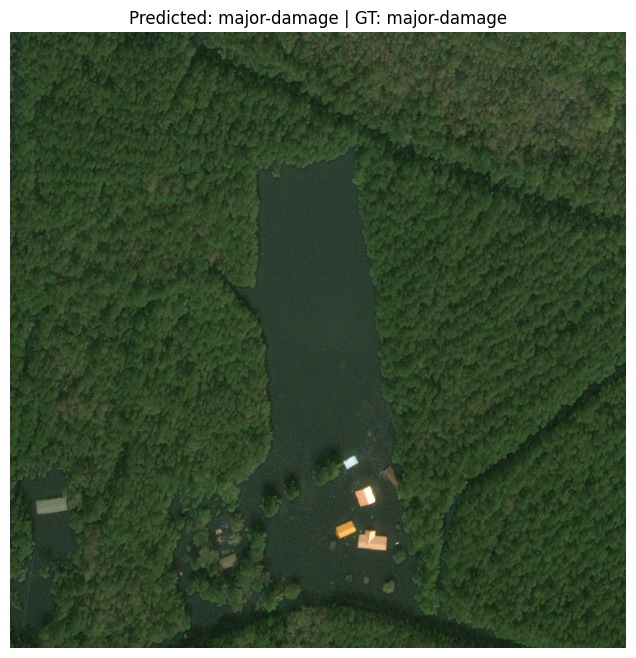

In [60]:
vis_ds = XBD_TestVis("test", transform=val_tf)

idx = 699   # any building
pre_t, post_t, full_post_img, poly, gt_label = vis_ds[idx]

# Convert tensors → numpy model input
pre_in  = pre_t.unsqueeze(0).to(device)
post_in = post_t.unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(pre_in, post_in)
    pred_label = logits.argmax(1).item()

visualize_polygon_damage(full_post_img, poly, pred_label, gt_label)